In [8]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

from skimage.color import rgb2lab, lab2rgb
from torchvision import transforms as T
import torch
import cv2
import os
import glob
from matplotlib import pyplot as plt
import numpy as np

# Load Model

In [3]:
body = create_body(resnet18, pretrained=True, n_in=1, cut=-2)
net_G = DynamicUnet(body, 2, (256, 256)).to('cuda')
net_G.load_state_dict(torch.load('model/color_gen.pt'))
net_G.to('cuda')
net_G.eval()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

In [5]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if name == 'L':
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
    plt.show()

# Run inference

In [4]:
os.chdir('../')

In [6]:
images = glob.glob('data/images/Test/*.jpg')

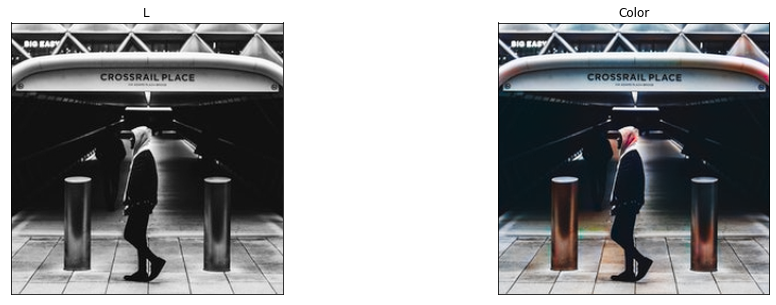

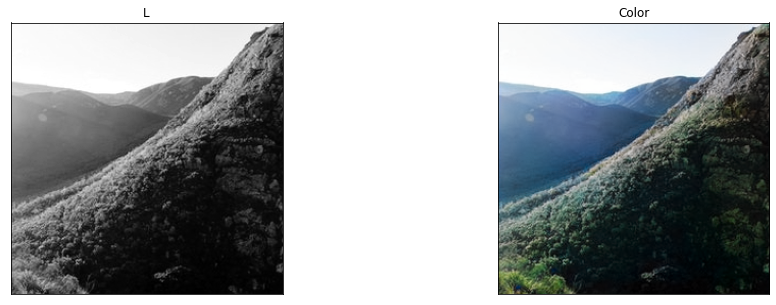

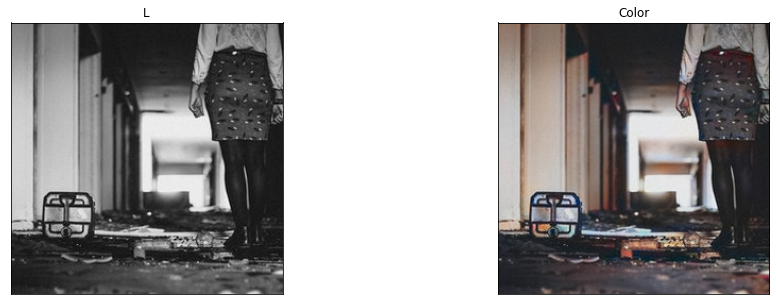

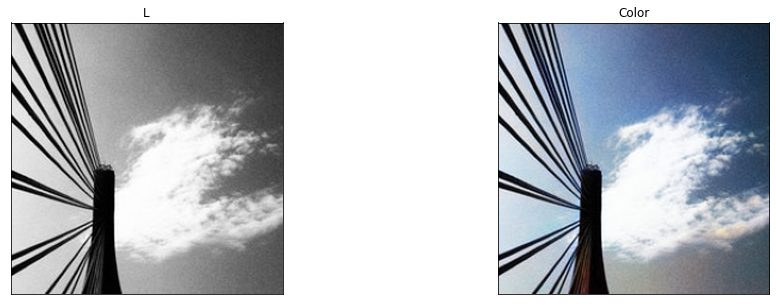

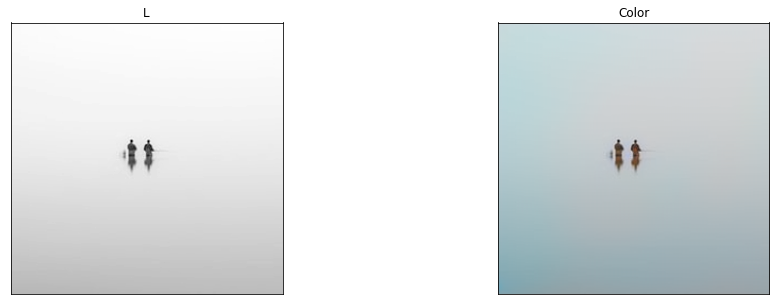

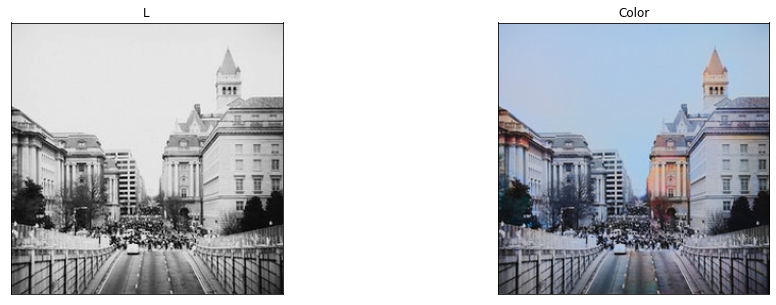

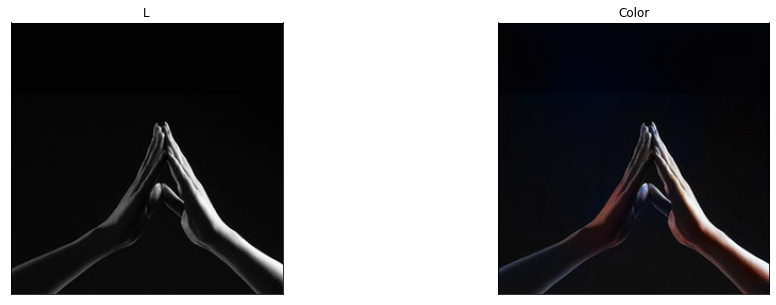

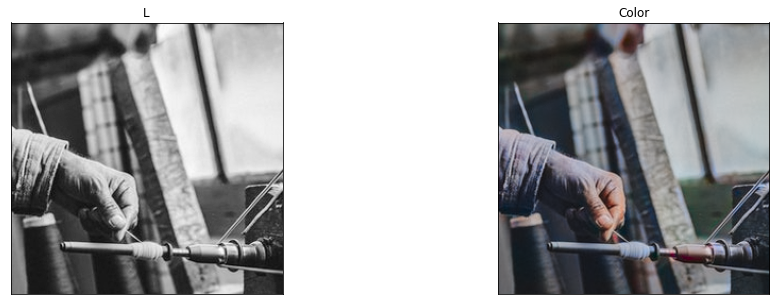

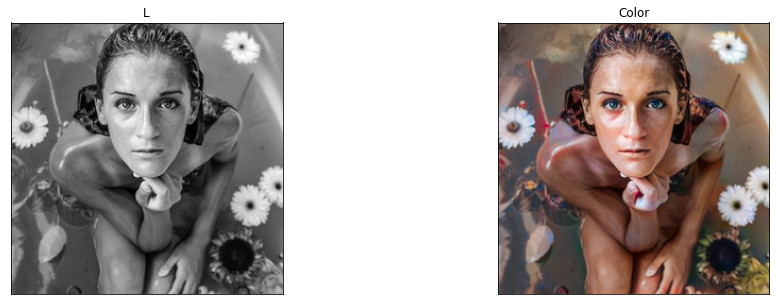

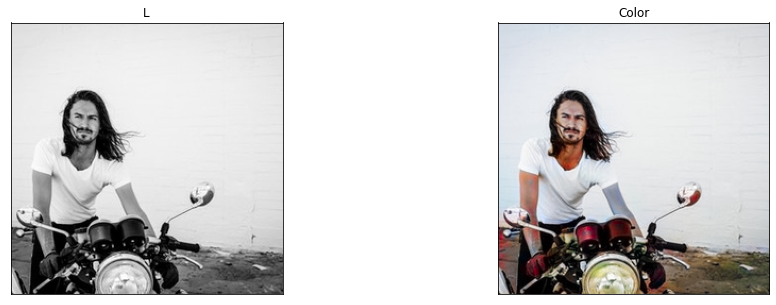

In [18]:
for image in np.random.choice(images, size=10):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    lab_img = rgb2lab(img).astype(np.float32)
    lab_img = T.ToTensor()(lab_img)
    L = lab_img[[0], ...] / 50. - 1. # Between -1 and 1
    
    with torch.no_grad():
        pred_ab = net_G(L.unsqueeze(0).to('cuda'))
    
    L_true = lab_img[[0], ...]
    pred_ab = pred_ab * 110.
    Lab_pred = torch.cat([L_true, pred_ab.squeeze(0).cpu()])

    Lab_pred = Lab_pred.permute(1, 2, 0).numpy()
    visualize(
        L=L_true.permute(1, 2, 0).numpy(), color=lab2rgb(Lab_pred)
    )